kaggle 링크 : https://www.kaggle.com/competitions/spaceship-titanic

In [ ]:
#필요한 라이브러리 import 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#train, test file 불러오기
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
#passengerId, Name, Destination 칼럼 드랍.
train = train.drop(columns = ['PassengerId', 'Name', 'Destination'])

#cabin의 첫번째 , 세번째 문자 는 각자 새로운 열(cabin_1, cabin_3 ) 로 만든다.
train['Cabin_1'] = train['Cabin'].str.split('/').str.get(0)
train['Cabin_3'] = train['Cabin'].str.split('/').str.get(2)

#기존 열(복잡하게 생긴...) cabin 은 drop 한다
train = train.drop(columns = 'Cabin')

# 수치형 데이터로 변환(get_dummies)
train = pd.get_dummies(train)
train = train.dropna()

#test 데이터도 마찬가지로 전처리 함. 
test = test.drop(columns = ['PassengerId', 'Name', 'Destination'])
test['Cabin_1'] = test['Cabin'].str.split('/').str.get(0)
test['Cabin_3'] = test['Cabin'].str.split('/').str.get(2)
test = test.drop(columns = 'Cabin')
test = pd.get_dummies(test)
test = test.dropna()

In [ ]:
train = train.drop(columns = ['CryoSleep_False', 'VIP_False'])
test = test.drop(columns = ['CryoSleep_False', 'VIP_False'])

In [ ]:
# # CryoSleep, VIP, Transported 의 True/False값을 각각 1/0으로 변환
# train['CryoSleep'][train['CryoSleep'] == False] = 0
# train['CryoSleep'][train['CryoSleep'] == True] = 1
# train['VIP'][train['VIP'] == False] = 0
# train['VIP'][train['VIP'] == True] = 1
# train['Transported'][train['Transported'] == False] = 0
# train['Transported'][train['Transported'] == True] = 1

# test['CryoSleep'][test['CryoSleep'] == False] = 0
# test['CryoSleep'][test['CryoSleep'] == True] = 1
# test['VIP'][test['VIP'] == False] = 0
# test['VIP'][test['VIP'] == True] = 1

train.Transported[train.Transported == False] = 0
train.Transported[train.Transported == True] = 1

In [ ]:
train.Transport

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'CryoSleep_0', 'CryoSleep_1', 'VIP_0', 'VIP_1',
       'Cabin_1_A', 'Cabin_1_B', 'Cabin_1_C', 'Cabin_1_D', 'Cabin_1_E',
       'Cabin_1_F', 'Cabin_1_G', 'Cabin_1_T', 'Cabin_3_P', 'Cabin_3_S'],
      dtype='object')

In [ ]:
print("총7620명 중에서")
print("VIP는: ", train[train['VIP_1'] == 1]['Age'].count(), "명")
print("실종된 사람수는: ", train[train['Transported'] == 1]['Age'].count(), "명")
print("냉동 수면은: ", train[train['CryoSleep_1'] == 1]['Age'].count(), "명")
print("화성 출발은: ", train[train['HomePlanet_Mars'] == 1]['Age'].count(), "명")
print("지구 출발은: ", train[train['HomePlanet_Earth'] == 1]['Age'].count(), "명")
print("목성 출발은: ", train[train['HomePlanet_Europa'] == 1]['Age'].count(), "명")

총7620명 중에서
VIP는:  178 명
실종된 사람수는:  3831 명
냉동 수면은:  2618 명
화성 출발은:  1539 명
지구 출발은:  4018 명
목성 출발은:  1881 명


In [ ]:
train.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Cabin_1_A,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_P,Cabin_3_S
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,0,1,0,...,1,0,0,0,0,0,0,0,1,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,1,0,0,...,0,0,0,0,0,0,1,0,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,1,0,0,...,0,0,0,0,0,0,1,0,0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,0,1,0,...,0,0,0,0,1,0,0,0,0,1


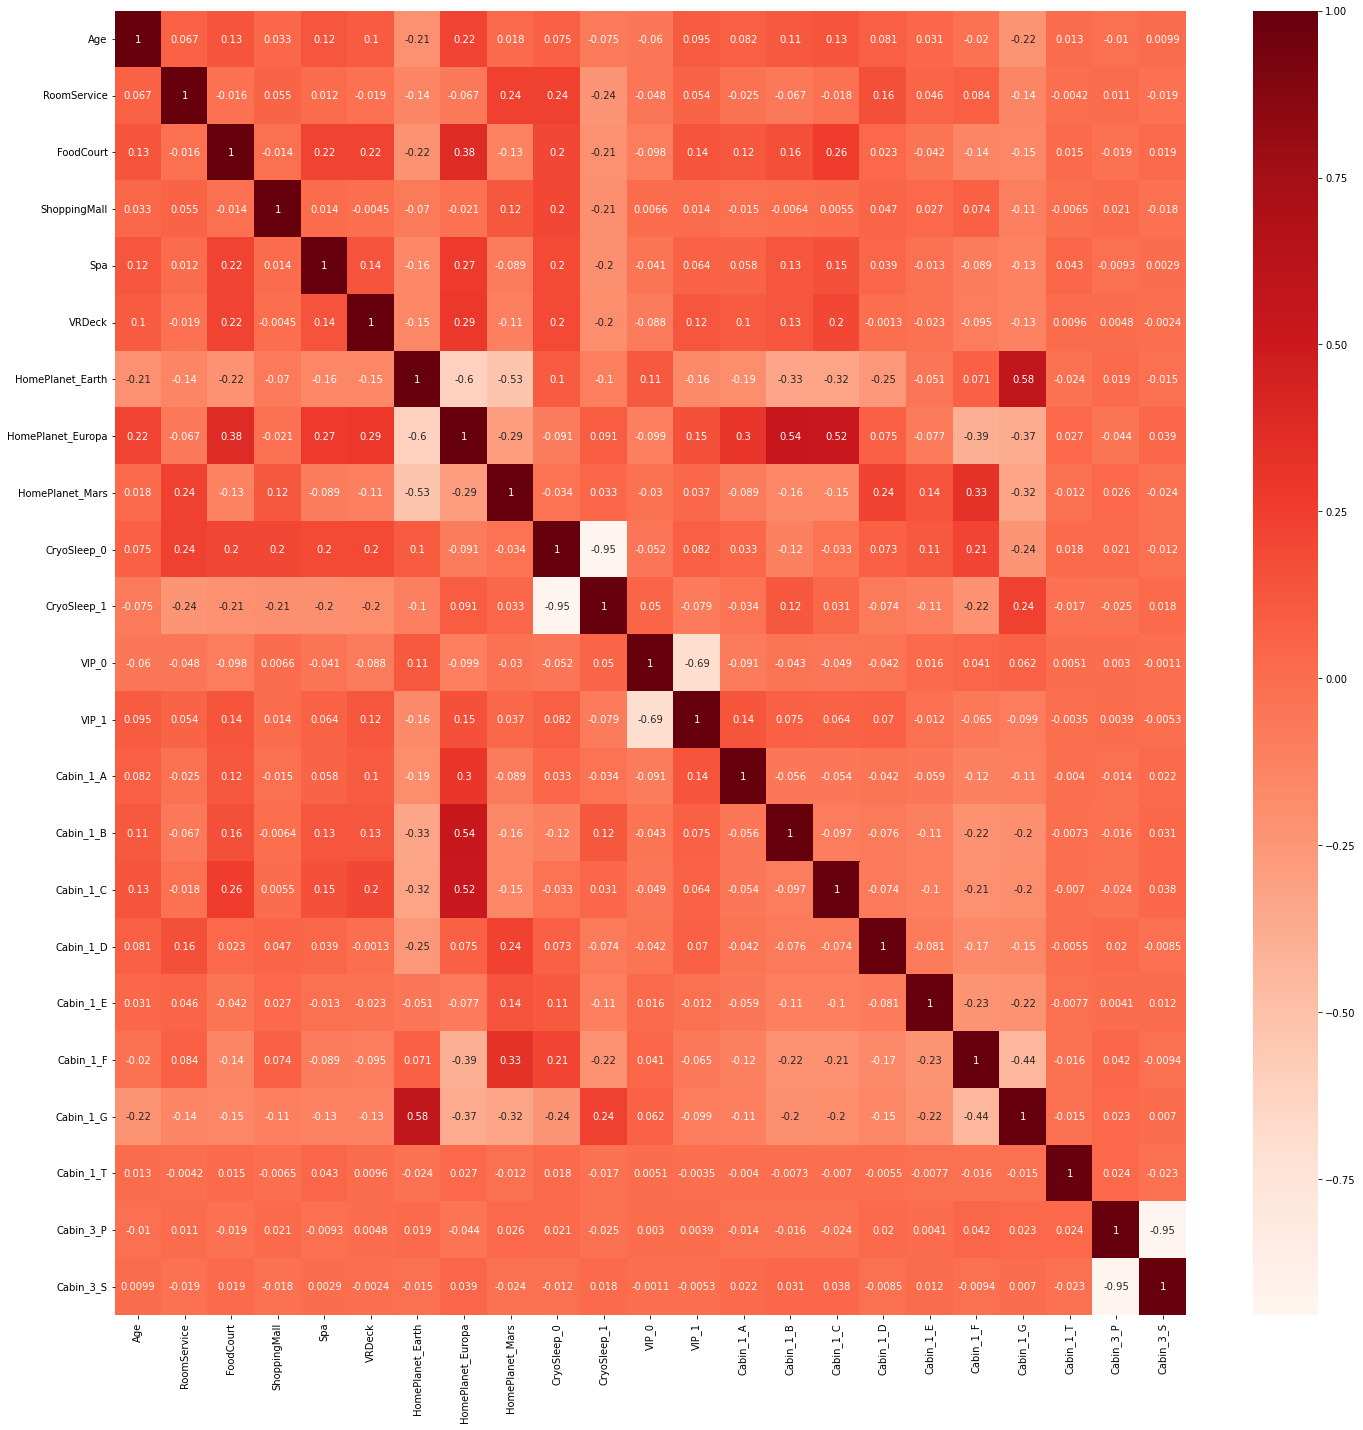

In [ ]:
fig, ax = plt.subplots(figsize=(24, 24))         # Sample figsize in inches

sns.heatmap(train.corr(), cmap='Reds', annot=True, ax=ax)

In [ ]:
# x, y 분리 및 y의 True/False값 변환
x = train.drop(columns = 'Transported')
y = train.Transported
y[y == True] = 1
y[y == False] = 0
y = y.astype(float)

In [ ]:
#test, train 분리 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 137, stratify = y)

In [ ]:
#model 구축
model = Sequential()
model.add(Dense(30, input_dim = x.shape[1], activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                720       
                                                                 
 dense_5 (Dense)             (None, 20)                620       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model 저장 설정
model_path = './space.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 20)
mc = ModelCheckpoint(monitor = 'val_loss', filepath = model_path, save_best_only = True, verbose = 0)

In [ ]:
#model compile, 학습
model.compile(loss='binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 2000, batch_size = 500, validation_split = 0.25, callbacks = [es, mc])

Epoch 1/2000
10/10 [==============================] - 1s 37ms/step - loss: 65.1943 - accuracy: 0.5122 - val_loss: 28.7343 - val_accuracy: 0.5545
Epoch 2/2000
10/10 [==============================] - 0s 13ms/step - loss: 15.0696 - accuracy: 0.5932 - val_loss: 7.6592 - val_accuracy: 0.5630
Epoch 3/2000
10/10 [==============================] - 0s 12ms/step - loss: 5.5950 - accuracy: 0.5626 - val_loss: 4.5140 - val_accuracy: 0.6877
Epoch 4/2000
10/10 [==============================] - 0s 13ms/step - loss: 4.2463 - accuracy: 0.7629 - val_loss: 3.5873 - val_accuracy: 0.7507
Epoch 5/2000
10/10 [==============================] - 0s 13ms/step - loss: 3.6177 - accuracy: 0.7533 - val_loss: 2.9261 - val_accuracy: 0.7533
Epoch 6/2000
10/10 [==============================] - 0s 28ms/step - loss: 2.8315 - accuracy: 0.7784 - val_loss: 2.3728 - val_accuracy: 0.7612
Epoch 7/2000
10/10 [==============================] - 0s 28ms/step - loss: 2.2892 - accuracy: 0.7708 - val_loss: 2.0660 - val_accuracy: 0.7

In [ ]:
# 테스트 데이터를 통한 검정
score = model.evaluate(x_test, y_test)
print("테스트 데이터 점수 : {}".format(score[1]))

48/48 [==============================] - 0s 1ms/step - loss: 0.6287 - accuracy: 0.7657
테스트 데이터 점수 : 0.7657480239868164
